# Conesa & Krueger (1999)
### John Ryan
This code was originally created for the solution to a problem set for Dean Corbae's computational economics course in Fall 2023. This was originally written in Julia, but is now translated to Python.

## Model

Each period a mass of workers is born, with constant population growth rate $n$ per period. Agents live for $N$ periods (adult years), with no stochastic mortality. Initial assets for each agent is $a_1 = 0$. Until age $j = J^R$, agents supply labor $\ell \in [0,1]$ to a representative firm. At age $J^R$, agents retire ($\ell = 0$) and earn pension benefits / social security $b$, which is financed by a linear labor income tax  with constant rate $\theta$. We assume the government keeps a balanced budget. Agents get period utility 

$$ u(c) - v(\ell) = \frac{c^{1-\sigma}}{1-\sigma} - \frac{\ell^{1+\gamma}}{1+\gamma} $$

with a constant discount factor of $\beta$. Workers have productivity $e(z, j) = z*\eta_j$, where $\eta_j$ is a deterministic age-efficiency profile, and $z$ is a Markov process with an initial ergodic distribution at birth. There is a representative firm with production technology

$$ Y = K^\alpha L^{1-\alpha} $$

where $\alpha \in (0, 1)$ and labor depreciates at constant rate $\delta$. Labor and capital markets are assumed to be perfectly competitive. To solve the model computationally, we assume $z$ follows a 2 state Markov chain and take the following benchmark parameterization:

| Parameter | Value | Description |
| --- | --- | --- |
| $n$ | .011 | population growth rate |
| $N$ | 66 | length of adult life |
| $J^R$ | 46 | age of retirement |
| $\theta$ | .11 | income tax rate |
| $\gamma$ | .40 | Frisch elasticity of labor supply |
| $\sigma$ | 2 | coefficient of relative risk aversion for consumption|
| $\beta$ | .97 | discount factor | 
| $\alpha$ | .36 | capital share |
| $\delta$ | .06 | capital depreciation |
| $z_H $ | 2.0 | high productivity value |
| $z_L$ | .3 | low productivity value |
| $\pi_H$ | .2037 | high productivity initial probability |
| $\pi_{HH}$ | .9261 | high productivity persistence probability |
| $\pi_{LL}$ | .9811 | low productivity persistence probability |
| $\eta_j$ | plotted below | age efficiency profile |



---

## Part 1

First we solve the dynamic programming problem for a retiree and worker. For now we assume the values $r=.05, w=1.05, b=.2$, but these will be solved for later. We start at the end of life, $j=N$, and iterate backwards. We normalize the value of death to $V_{N+1} = 0$.

A retiree has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0} u((1 + r)a + b − a') + βV_{j+1}(a'),$$

Where they supply no labor, and we have used the budget constraint $c + a' = (1+r)a + b$. We exploit the fact that there is no bequest motive, so at the age of death, agents consume all of their wealth, $a'=0$. 

A worker has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0, 0 \le \ell \le 1} u(w(1 - \theta)e(z, \eta_j)\ell + (1+r)a - a') - v(\ell) + \beta \mathbb{E}[V_{j+1}(a',z')|(a,z,j)]$$

We have plugged in the budget constraint $c + a' = w(1-\theta)e(z, j)\ell + (1+r)a$ into the utility function. We can use the first order condition of the household to solve for labor: 

$$ \frac{v'(\ell)}{u'(c)} =  w(1 - \theta)e(z, \eta_j)$$

So that we can simplify the problem to the household just choosing $a'$ in 
each period as a function of their state $(j, a, z)$ and 
the next period's value function $V_{j+1}$. The policy function is $a_j '(a, z)$. 
The household's labor supply is then $\ell_j(a,z)$.


Text(0.5, 1.0, 'Age-efficiency profile')

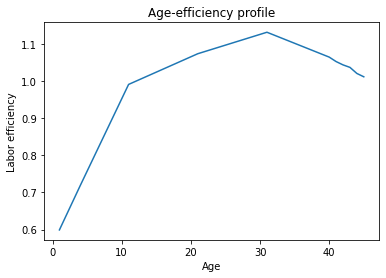

In [1]:
import numpy as np
# include OLGModel class from OLG_functions.py
from OLG_functions_fast_Frisch import OLGModel, V_induction, steady_dist, market_clearing
import matplotlib.pyplot as plt

# read in ef.txt as a numpy array
ef = np.loadtxt('ef.txt', delimiter=',')

# plot ef across [1, .., len(ef)]
x = np.arange(1, len(ef)+1)
plt.plot(x, ef)
plt.xlabel('Age')
plt.ylabel('Labor efficiency')
plt.title('Age-efficiency profile')

First, we will use grid search to solve for the household value functions and policy functions.

In [12]:
OLG = OLGModel(a_max=35.0, na=2000, eta=ef)

# solve HH problem
V_r, g_r, c_r, V_w, g_w, c_w, l_w = V_induction(OLG)

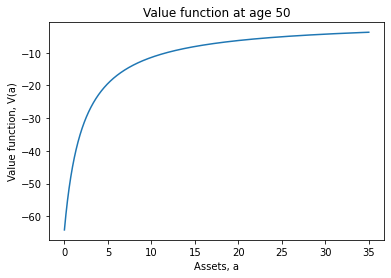

In [42]:
plt.plot(OLG.a_grid, V_r[4, :])
plt.xlabel('Assets, a')
plt.ylabel('Value function, V(a)')
plt.title('Value function at age 50')
plt.show()

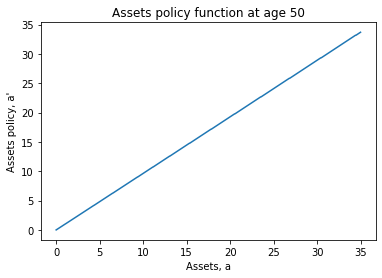

In [41]:
plt.plot(OLG.a_grid, g_r[4, :])
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
plt.title('Assets policy function at age 50')
plt.show()

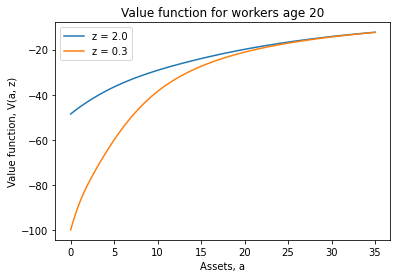

In [44]:

# Plot V_w for each value of z
j = 20
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, V_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Value function, V(a, z)')
plt.title('Value function for workers age 20')
plt.legend()
plt.show()

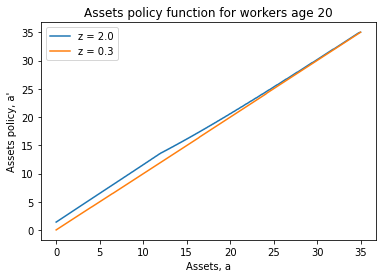

In [45]:
# Plot g_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, g_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
plt.title('Assets policy function for workers age 20')
plt.legend()
plt.show()

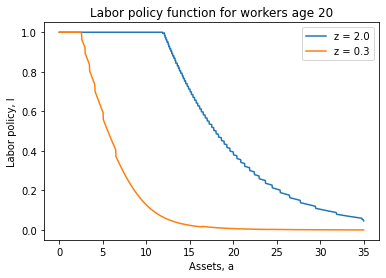

In [46]:
# Plot l_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, l_w[j-1, :, i], label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l')
plt.title('Labor policy function for workers age 20')
plt.legend()

## Part 2

Here we solve for the stationary distribution of agents across age, productivity and wealth given the choices of households, $F_j(z, a)$. First we find the relative size of each cohort of age $j$ (denoted $\mu_j$) with 

$$ \mu_{j+1} = \frac{\mu_j}{1+n} $$ 

for each $j = 1, 2, ..., N-1$.

Then, we normalize so that $\sum_j \mu_j = 1$. Then we get the initial distribution by $F_1(z_H, 0) = \mu_1 \pi_H$, $F_1(z_L, 0) = \mu_1 \pi_L$, and then iterate forward using policy functions. Note that since retired workers are not characterized by their productivity, the distribution of retired workers is just over age and assets. 

In [27]:
F_r, F_w = steady_dist(OLG, g_r, g_w)

In [28]:
F_w[0, 0, :]

array([0.00435517, 0.01702514])

In [29]:
OLG.a_grid[73]

0.21435719942597425

In [30]:
# proportion of workers
np.sum(F_w)

0.7639686707684408

In [31]:
# proportion of retirees
np.sum(F_r)

0.23603132923155584

Text(0.5, 1.0, 'Distribution of agents by assets')

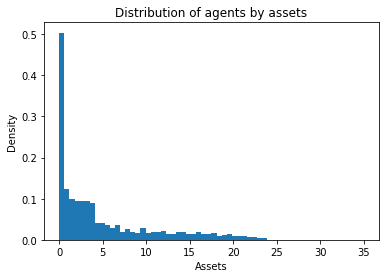

In [32]:
F_w_collapsed = np.sum(F_w, axis=(0, 2))
F_r_collapsed = np.sum(F_r, axis=0)
F_collapsed = F_w_collapsed + F_r_collapsed

# histogram of the distribution of agents by assets
plt.hist(OLG.a_grid, weights=F_collapsed, bins=60, density=True)
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title('Distribution of agents by assets')

---

## Part 3

Here we solve for a steady state in the benchmark model (described above). The algorithm is as follows:

1. Make initial guess for aggregates $K_0$, $L_0$
2. Solve for implied wage $w_0$ and interest rate $r_0$ using firm first order conditions
3. Use government budget constraint to solve for retirement benefits $b = \theta w_0 L_0 / \sum_{j=J^R}^N \mu_j$
4. Solve the household problem for value and policy functions given prices and retirement benefits
5. Find the implied distribution of wealth
6. Solve for the implied aggregate values $K_{new}$, $L_{new}$
7. Iterate aggregates in the direction of the new values, $K_1 = \rho K_{new} + (1-\rho) K_0$, $L_1 = \rho L_{new} + (1-\rho) L_0$ for small $\rho$
8. Take new values as the initial guess and iterate until $\max\{|K_{new} - K_0|, |L_{new} - L_0|\} < \varepsilon$

In [33]:
market_clearing(OLG, rho=.25, tol=.0005, K0=3.34, L0=.34)

K = <object type:float64>, L = <object type:float64>
Converged in 26 iterations


(4.384735033085841,
 0.47395695747366373,
 0.02668215757792472,
 1.425655741008715,
 0.3046451502591815)

---

## Endogenous Grid Method

Here we will use an implementation of the endogenous grid method to speed up the code as well as improve its accuracy.

We will have a slightly different algorithm for retired agents than workers. For a retired agent, their problem is just the cake eating problem as they just consume out of their wealth. 

We will utilize the Euler equation for the household. From the retired household DP problem, we have the final value function in closed form:

$$ V_N(a) = u((1+r)a)$$

Thus, we also have

$$V_N'(a) = (1+r)u'((1+r)a) = (1+r) u'((1+r)a)$$

Next, we have the envelope condition for a household in period t:

$$ V'_{j}(a_j) = (1+r) u'(c_j)$$

and finally, the household FOC:

$$ u'(c_j) = \beta V'_{j+1}(a_{j+1}) $$

This implies an Euler equation which holds for each period of retirement:

$$ u'(c_j) = \beta (1+r) u'(c_{j+1}) $$

This could also be derived using the sequence problem of the household upon retirement. 

The algorithm for a retired worker is as follows:

1. Initialize a grid of final asset values $A_N $
2. From the household's budget constraint find $c_N = (1+r) a_N$ (the household consumes all of their wealth at end of life)
3. Use the household's Euler equation to solve for the implied preceding consumption path: $u'(c_{j-1}) = \beta (1+r) u'(c_j)$
4. Use budget constraints in each priod to find the level of assets in each time period: $a_j = \frac{c_j + a_{j+1}}{1+r} $.
5. Interpolate the consumption policy function $c_j(a)$ at each age $j$
6. Evaluate the policy functions on an exogenous grid.
7. If you still want value functions, they can be solved for brute force by finding the present discounted utility from the consumption path associated with a level of assets.


For a worker, the problem is slightly more complicated because of the larger state space and the labor choice. The state space for a worker is assets $a$ and a realization of productivity $z$. Recall the dynamic programming problem of the household is:

$$ 
\begin{align*}
V_j(a, z) = \max_{a' \ge 0, 0 \le \ell \le 1, c} \quad &u(c) - v(\ell) + \beta \mathbb{E}[V_{j+1}(a',z')|(a,z,j)]\\
 &s.t. \quad c + a' = w * z * \eta_j * (1-\theta) * \ell + (1+r)a

\end{align*}
$$

This implies 2 optimality conditions, an intertemporal Euler equation and an intratemporal consumption - labor optimality condition. The Euler equation for a worker is:

$$ u'(c_j) = \beta (1+r) \mathbb{E}_j[u'(c_{j+1})| z] $$

The intratemporal optimality condition is

$$ v'(\ell) \leq w *u'(c)$$

Which holds with equality if $\ell$ is interior


In [14]:
from OLG_EGM_slow import OLGModel as OLG_EGM
from OLG_EGM_slow import HH_egm

og = OLG_EGM(eta=ef)
a_policy_r, a_policy_w, c_policy_r, c_policy_w, l_policy, a_grids = HH_egm(og)

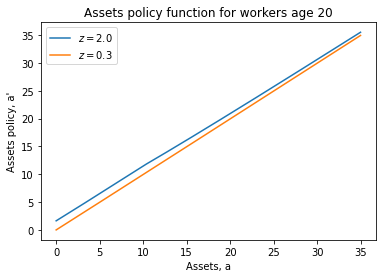

In [48]:
import matplotlib.pyplot as plt

j = 20 # specify the value of j
plt.plot(a_grids[j-1, :], a_policy_w[j-1, 0, :])
plt.plot(a_grids[j-1, :], a_policy_w[j-1, 1, :])
plt.xlabel('Assets, a')
plt.ylabel('Assets policy, a\'')
# set title
plt.title('Assets policy function for workers age 20')
plt.legend([f'$z={og.z_grid[0]}$', f'$z={og.z_grid[1]}$'])
plt.show()

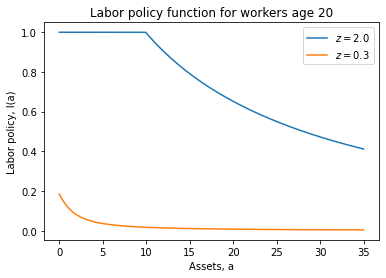

In [53]:
import matplotlib.pyplot as plt

 # specify the value of j
plt.plot(a_grids[19, :], l_policy[19, 0, :])
plt.plot(a_grids[19, :], l_policy[19, 1, :])
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l(a)')
# set title
plt.title('Labor policy function for workers age 20')
plt.legend([f'$z={og.z_grid[0]}$', f'$z={og.z_grid[1]}$'])
plt.show()

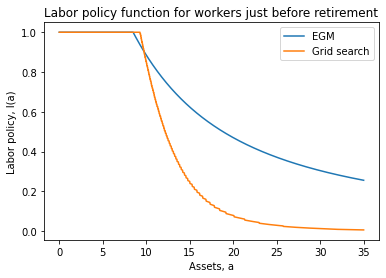

In [52]:
plt.plot(a_grids[-1, :], l_policy[-1, 0, :], label='EGM')
plt.plot(OLG.a_grid, l_w[-1, :, 0], label='Grid search')
plt.xlabel('Assets, a')
plt.ylabel('Labor policy, l(a)')
# set title
plt.title('Labor policy function for workers just before retirement')
plt.legend()